In [1]:
from src.thickness_dataset import ThicknessDataset, ToTensor
from src.models import U_Net
from src.trainer import Trainer

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

PATH = "data\gen_data_6000_v2"

In [2]:
augs = A.Compose([A.Normalize(mean = (0, 0, 0),
                              std  = (1, 1, 1)),
                 ToTensorV2()])
thickness_dataset = ThicknessDataset(PATH, transform=augs)

# Calculate mean and std
image_loader = DataLoader(thickness_dataset, 
                          batch_size  = 128, 
                          shuffle     = False, 
                          num_workers = 4,
                          pin_memory  = True)

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum    += inputs['img'].sum(axis        = [0, 2, 3])
    psum_sq += (inputs['img'] ** 2).sum(axis = [0, 2, 3])

# pixel count
count = len(thickness_dataset) * 128 * 128

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

100%|██████████| 52/52 [00:32<00:00,  1.61it/s]


In [3]:
train_split = 0.7
valid_split = 0.1

augs = A.Compose([A.Normalize(mean = total_mean,
                              std  = total_std),
                 ToTensorV2()])
thickness_dataset = ThicknessDataset(PATH, transform=augs)



train_size = int(train_split * len(thickness_dataset))
valid_size = int(valid_split * len(thickness_dataset))
test_size = len(thickness_dataset) - (train_size+valid_size)
train_dataset,valid_dataset ,test_dataset = torch.utils.data.random_split(thickness_dataset, [train_size, valid_size, test_size], generator=torch.Generator().manual_seed(42))

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=128)
print("# of samples in test set:", len(test_dataset))

# of samples in test set: 1311


In [8]:
no_of_batch =0
depth_sum = torch.zeros(1,128,128)
for batch in train_dataloader:
    # Get the depth maps for the batch
    thick_map = batch["thick_map"]
    # Accumulate the sum of depth maps and the number of pixels
    depth_sum += torch.mean(thick_map, dim=0)
    no_of_batch +=1
# Calculate the mean depth over all batches
mean_depth = depth_sum / no_of_batch
# show the mean depth in a graph
print("Mean depth over all batches:", mean_depth)

Mean depth over all batches: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


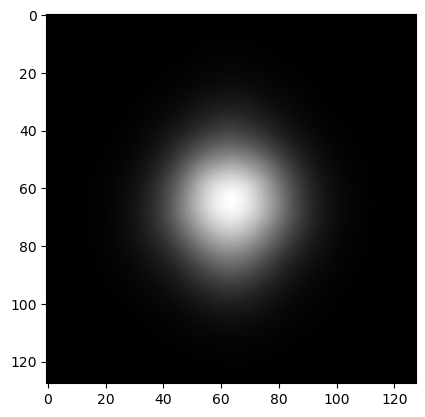

In [7]:
plt.imshow(mean_depth[0], cmap="gray")

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [14]:
# Get the masked loss for the test set quantative evaluation 
# https://torchmetrics.readthedocs.io/en/stable/image/peak_signal_noise_ratio.html
from skimage.metrics import structural_similarity as ssim
from src.evaluation import mse_loss_with_nans
from torchmetrics import PeakSignalNoiseRatio
full_loss = 0
fullstrsim = 0
full_mape = 0
batches = 0
mean_abs_percentage_error = PeakSignalNoiseRatio().to(device)

with torch.no_grad():
    for data in test_dataloader:
        labels = data['thick_map'].to(device, dtype=torch.float)
        # outputs = trained_model(images)
        # print(labels.shape[0])
        # using the length of the batch to calculate the mean of the batch

        outputs = torch.ones(labels.shape[0], 1, 128, 128).to(device, dtype=torch.float)
        outputs = outputs * mean_depth.to(device, dtype=torch.float)

        masked_loss = mse_loss_with_nans(outputs, labels)
        mape = mean_abs_percentage_error(outputs, labels)
        strsim = 0 
        for i in range(labels.cpu().numpy().shape[0]):
            strsim += ssim(outputs[i].cpu().numpy()[0], labels[i].cpu().numpy()[0])

        fullstrsim += strsim/labels.cpu().numpy().shape[0]
        full_mape += mape
        full_loss += masked_loss
        batches += 1
print("Test SSIM: {}".format(fullstrsim/batches))
print("Test loss: {}".format(full_loss/batches))
print("Test MAPE: {}".format(full_mape/batches))

Test SSIM: 0.7861875724906628
Test loss: 0.03829151391983032
Test MAPE: 22.418106079101562
